In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time
import utils

import os

root = '../../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

Try to train an ARIMA model on the previous time window to evaluate if the current contains outliers.

We want to keep a certain number of measurements to train the model.
For now use an amount equal to the expected number of measurements - in this way we keep lose only a partial amount of data.

In [3]:
from pmdarima import auto_arima

def ARIMA_slider(df, mins = 60, val_index = 2, ts_index = 1, tr_secs = 10):
    delta = np.timedelta64(mins,'m')
    tr = np.timedelta64(tr_secs, 's')
    expected_num_measurements = int(delta / tr)
    
    win_col = ['id', 'start', 'stop', '#out', '#in', '#miss']
    win_ret = pd.DataFrame(columns = win_col)
    
    point_col = ['id', 'ts', 'val', 'pred', 'l_thresh', 'h_thresh', 'is_in']
    point_ret = pd.DataFrame(columns = point_col)
    
    gen = utils.windows_generator(df, delta, ts_index)
    
    name = df.iloc[0,0]
    prev_window = pd.DataFrame()
    
    for start, end, window in gen:
    
        if len(window) == 0:
            continue
            
        #we have enough data?
        if len(prev_window) < expected_num_measurements:
            prev_window = prev_window.append(window)
            continue    
        
        # We have enough data! -> determine best model
        win_values = prev_window[2].values
        
        model = auto_arima(win_values, error_action="ignore", suppress_warnings=True)
        model.fit(win_values)
        
        # predict next values 
        preds, conf_int = model.predict(n_periods = int(expected_num_measurements), return_conf_int=True)
        
        n_out = 0
        n_in = 0
        
        for i in range(len(window)):
            frame = window.iloc[i,:]
            ts = frame[ts_index].astype('datetime64[ms]')
            value = frame[val_index]
            
            predicted = preds[i]
            lci = conf_int[i][0]
            hci = conf_int[i][1]
            
            if lci < value < hci:
                out = 1
                n_in += 1
            else:
                out = -1
                n_out +=1
            
            prev_window = prev_window.append(frame)
            prev_window = prev_window.iloc[1:,:]
                
            new_data = pd.DataFrame([[name, ts, value, predicted, lci, hci, out]], columns = point_col)
            point_ret = point_ret.append(new_data, sort = False)
        
        win_data = pd.DataFrame([[name, start, end, n_out, n_in, expected_num_measurements-n_in-n_out]], columns = win_col)
        win_ret = win_ret.append(win_data, sort = False)

              
    return win_ret, point_ret

In [4]:
res = []

<IPython.core.display.Javascript object>


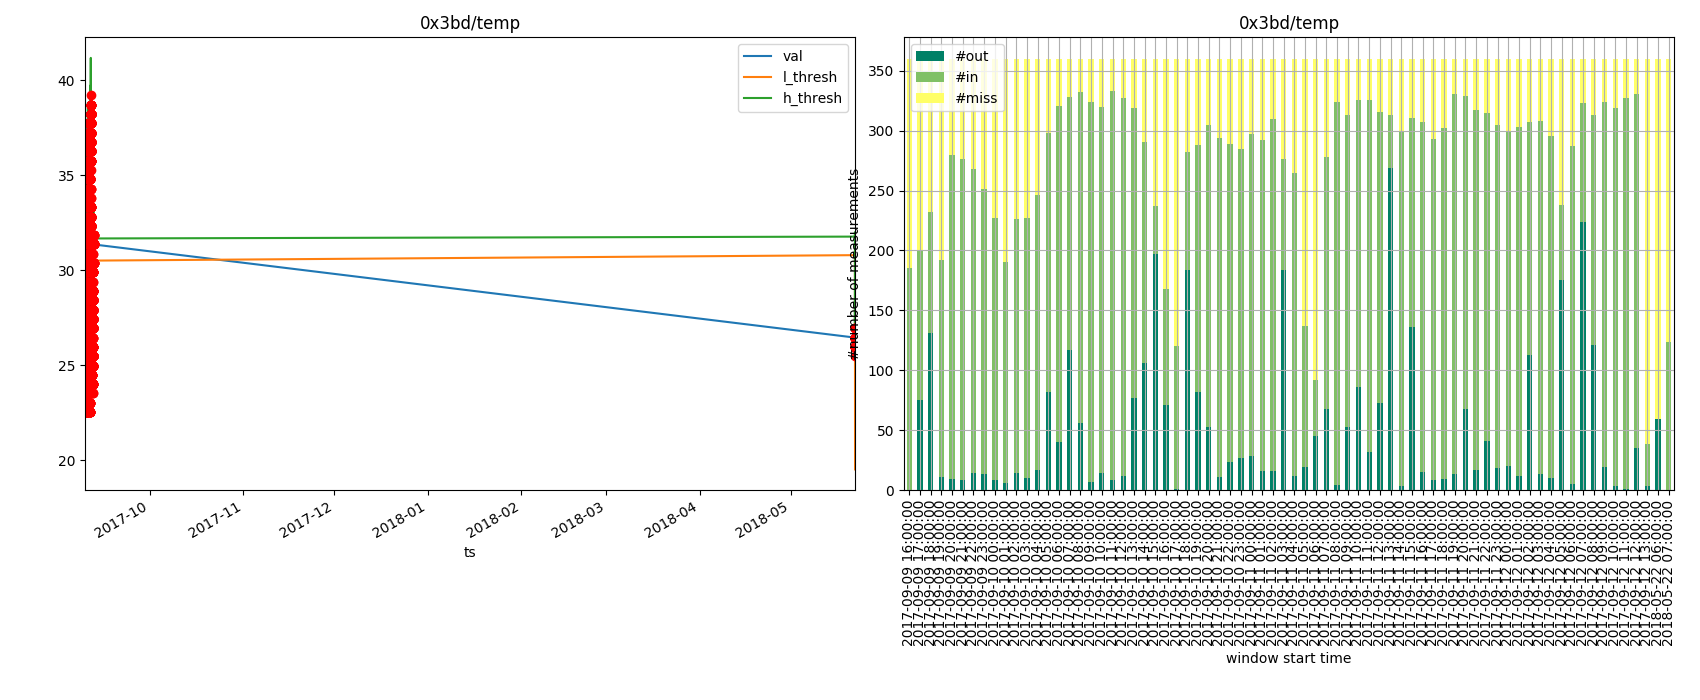

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

<IPython.core.display.Javascript object>


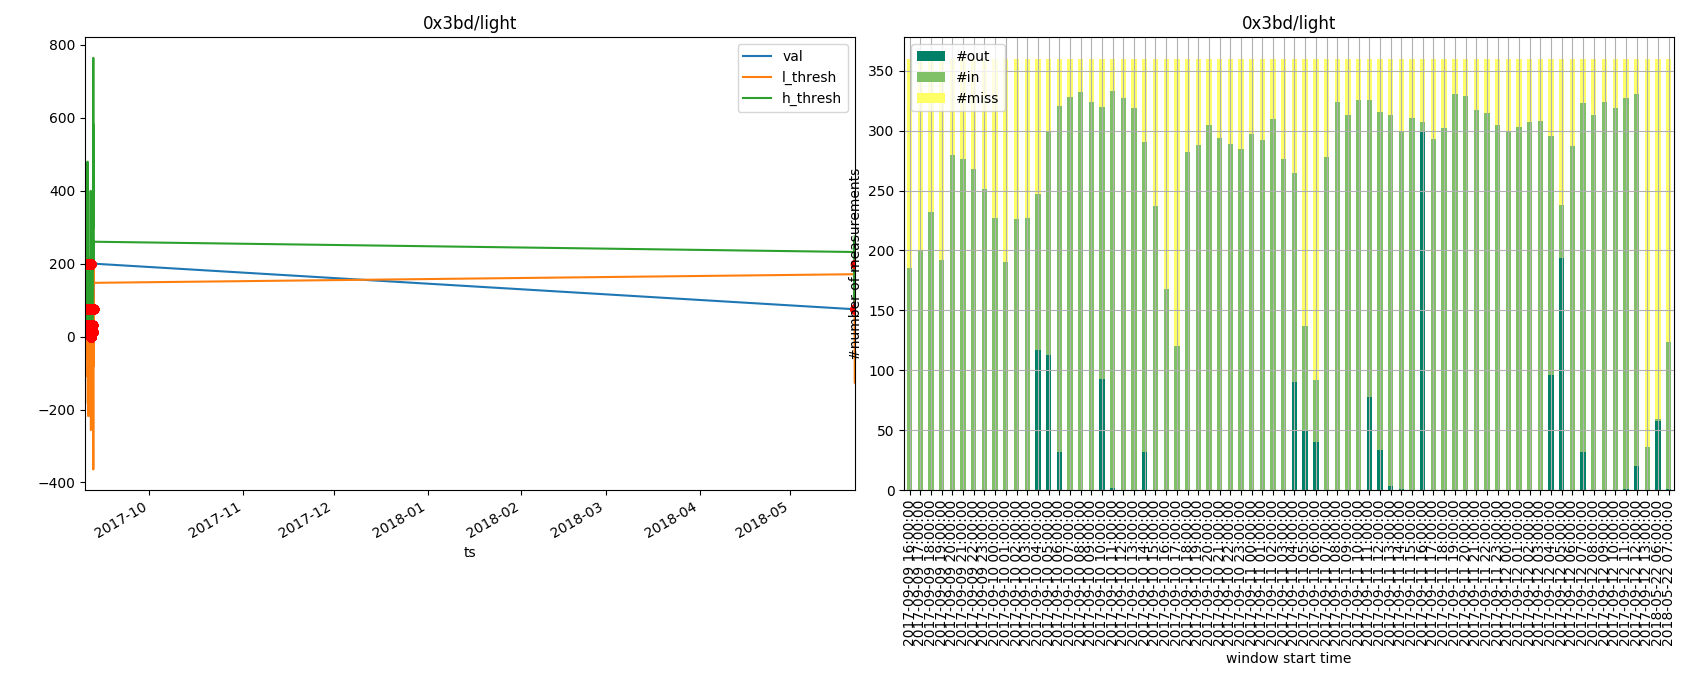

<IPython.core.display.Javascript object>


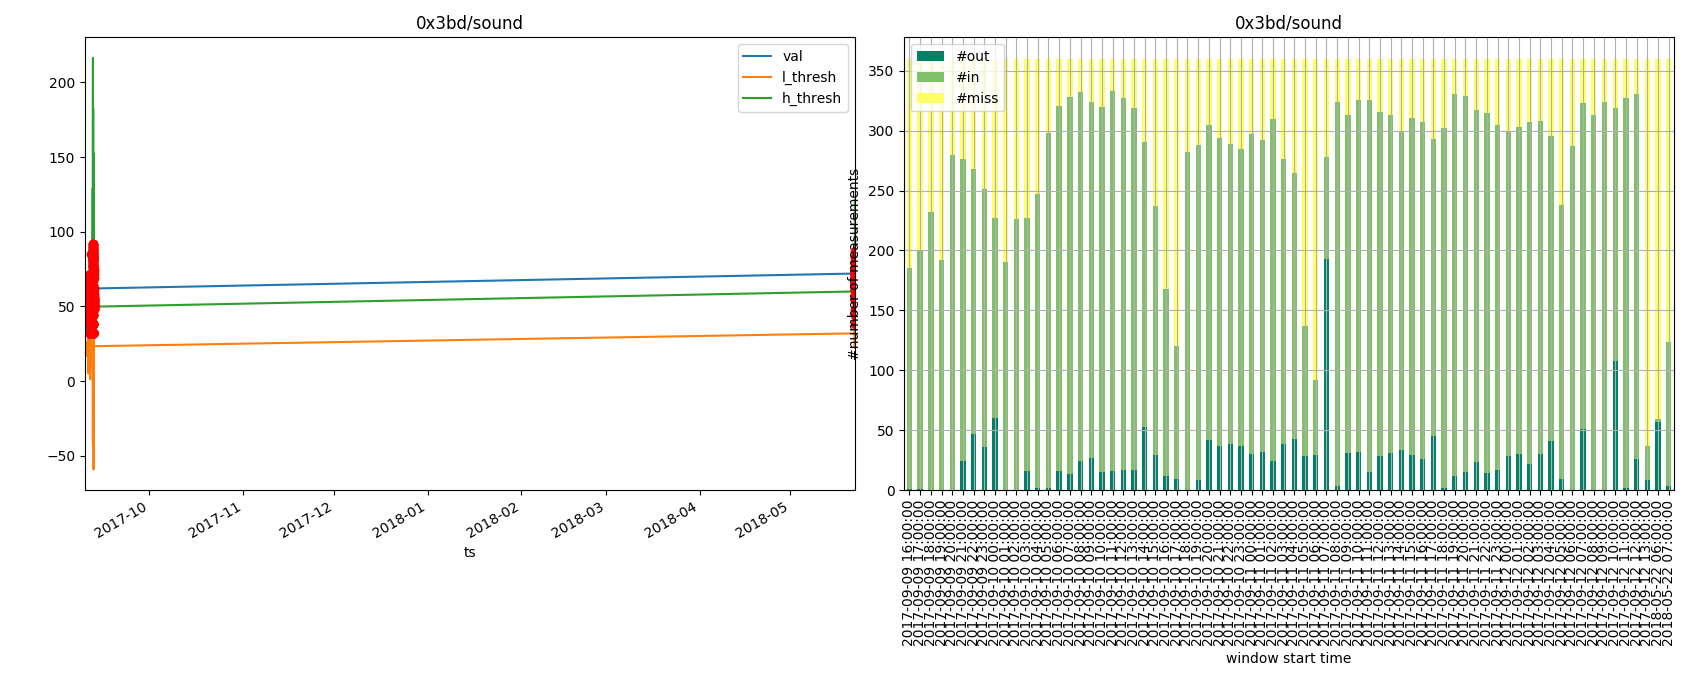

In [5]:
for x in [t_path[0], l_path[0], s_path[0]]:
    path = os.path.join(root, x)
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    #ARIMA_slider(df).plot.line(x=0, y=[1,2,3,4])
    y, x = ARIMA_slider(df)
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    x.plot(ax = ax[0], x = 1, y = [2,4,5], kind='line', title = name)
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[6]
        if boolean == -1:
            ax[0].plot(ts, val, 'ro-')
    ax[0].xaxis_date()

    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax[1], kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax[1].set_xlabel('window start time')
    ax[1].set_ylabel('#number of measurements')
    ax[1].xaxis_date()
    ax[1].legend()
    ax[1].grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
    
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


<IPython.core.display.Javascript object>


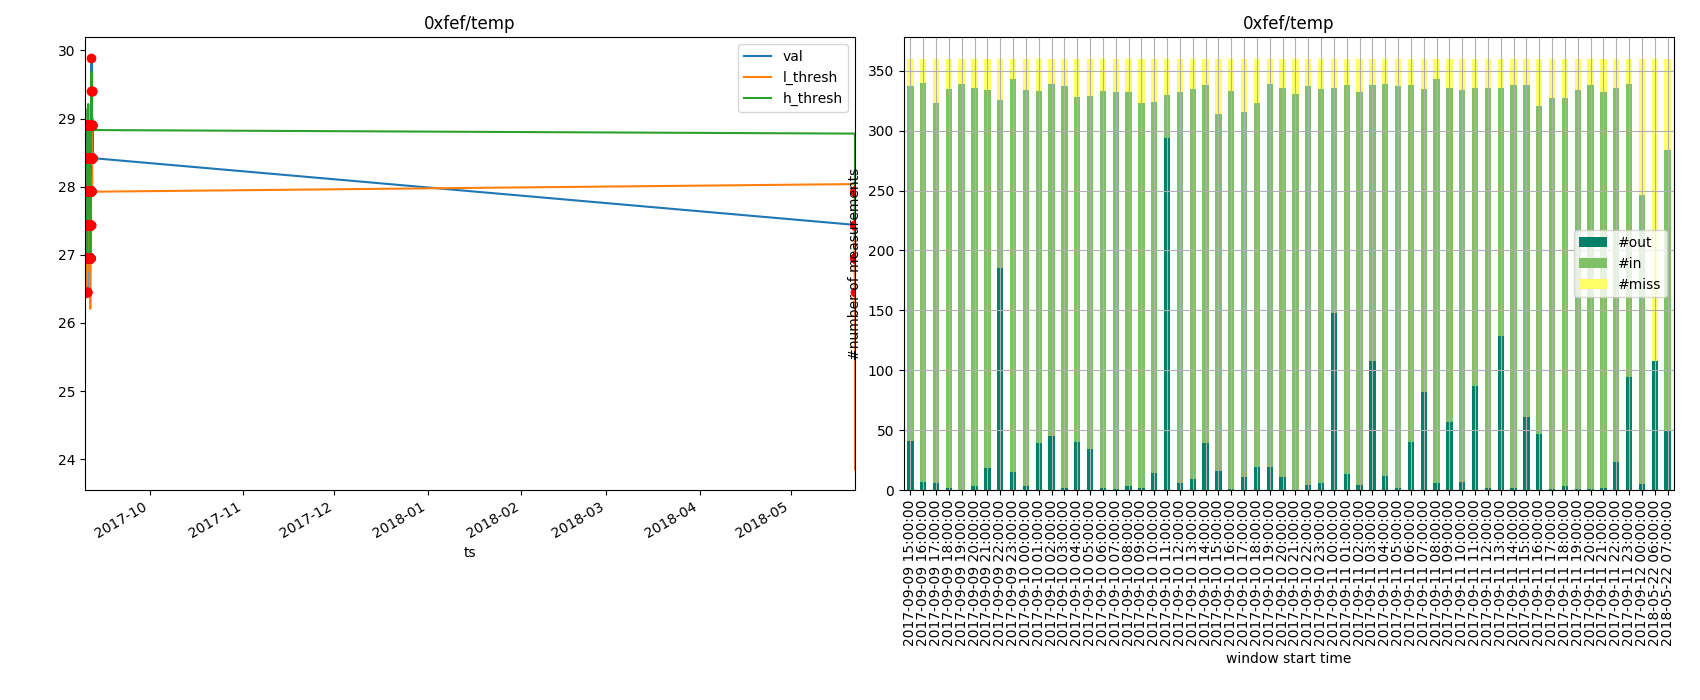

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


<IPython.core.display.Javascript object>


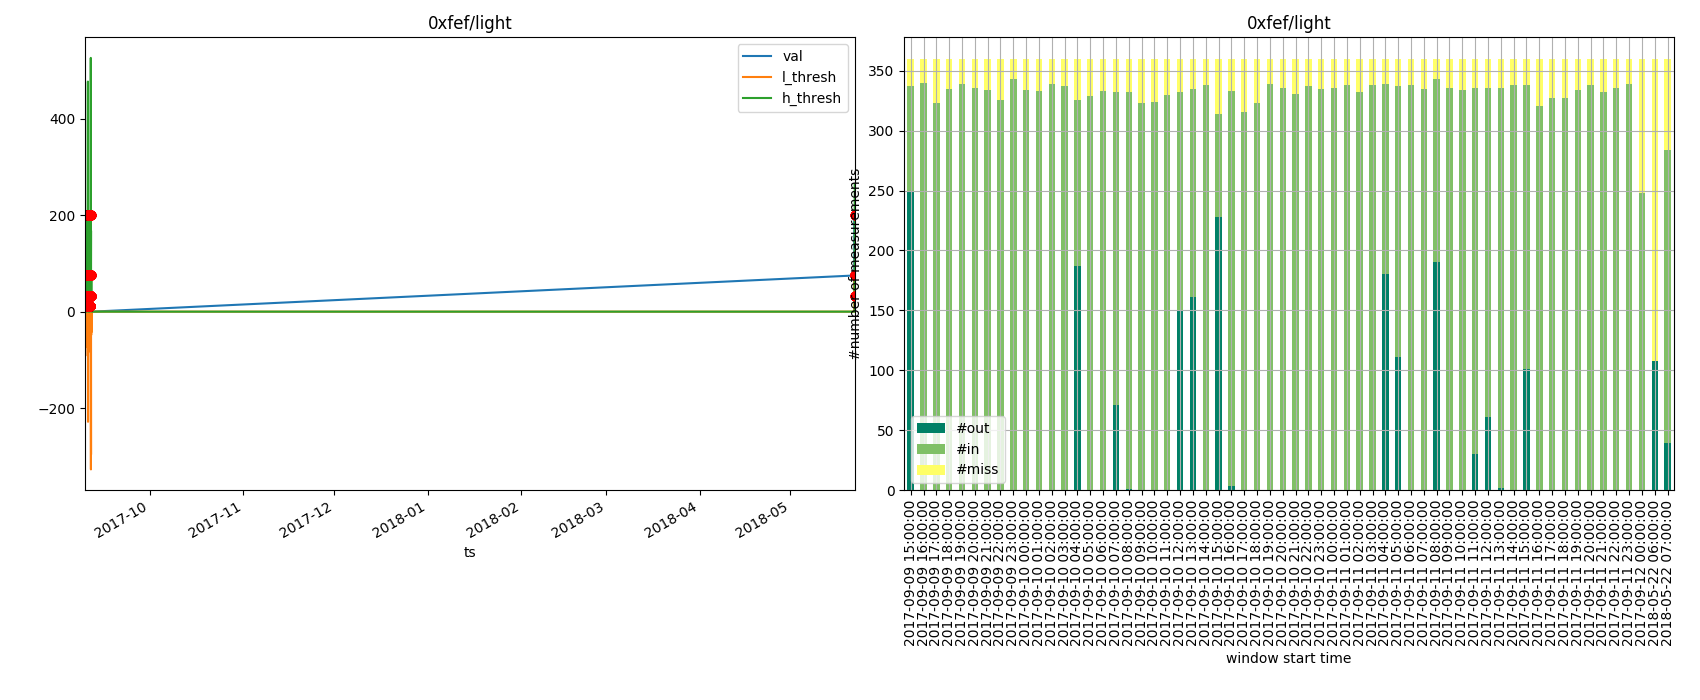

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

<IPython.core.display.Javascript object>


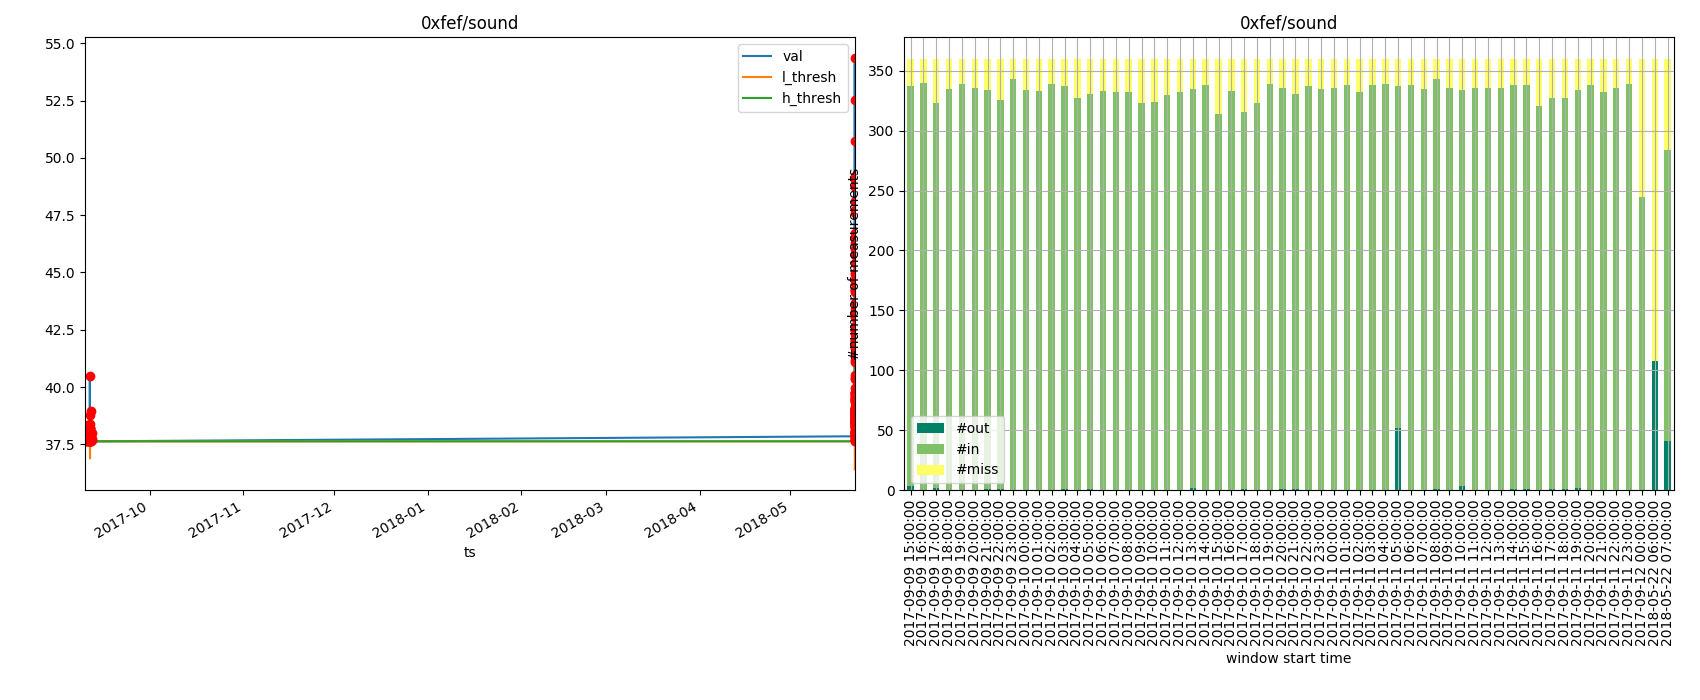

In [6]:
for x in [t_path[1], l_path[1], s_path[1]]:
    path = os.path.join(root, x)
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
        
    #ARIMA_slider(df).plot.line(x=0, y=[1,2,3,4])
    y, x = ARIMA_slider(df)
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    x.plot(ax = ax[0], x = 1, y = [2,4,5], kind='line', title = name)
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[6]
        if boolean == -1:
            ax[0].plot(ts, val, 'ro-')
    ax[0].xaxis_date()

    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax[1], kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax[1].set_xlabel('window start time')
    ax[1].set_ylabel('#number of measurements')
    ax[1].xaxis_date()
    ax[1].legend()
    ax[1].grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
    
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

<IPython.core.display.Javascript object>


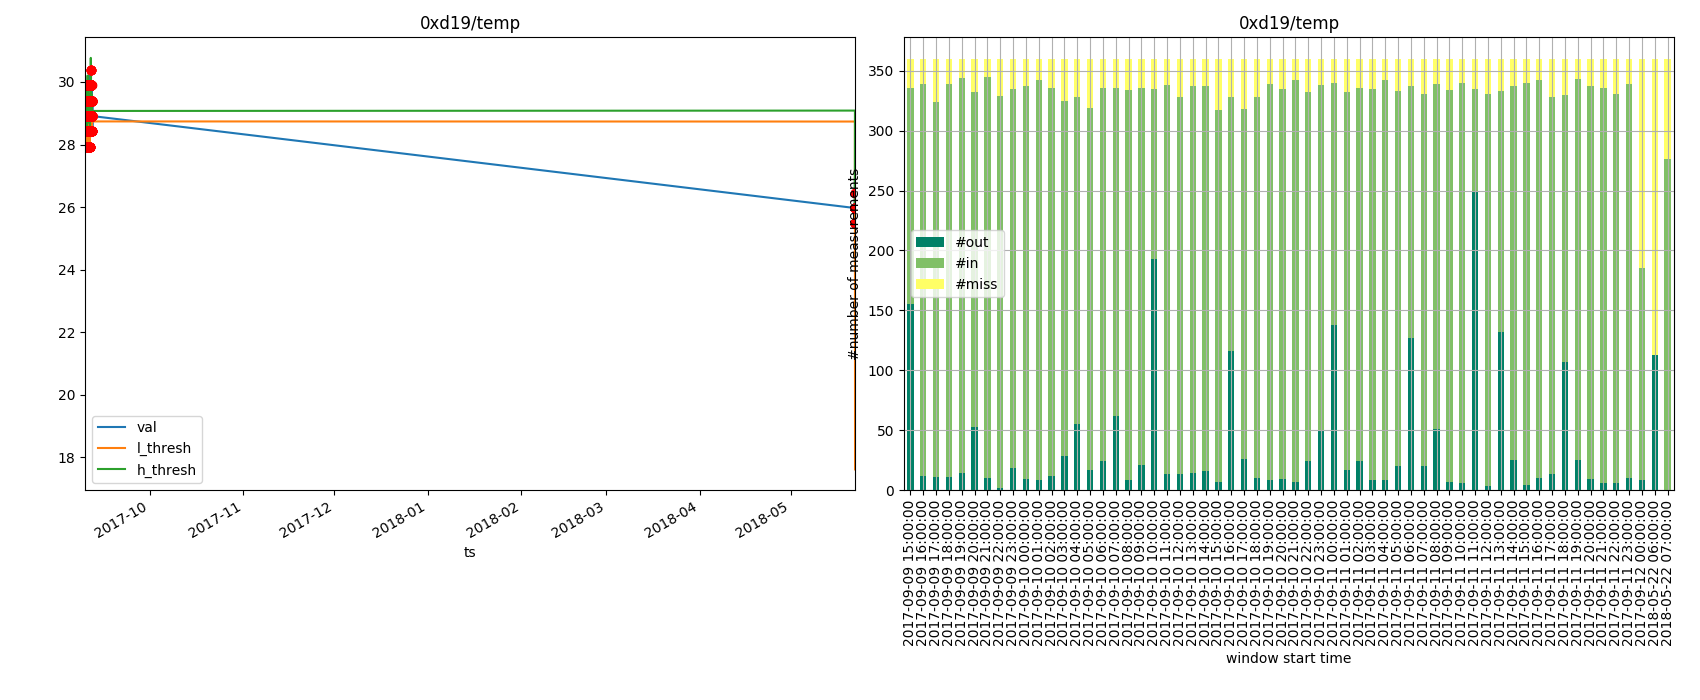

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

<IPython.core.display.Javascript object>


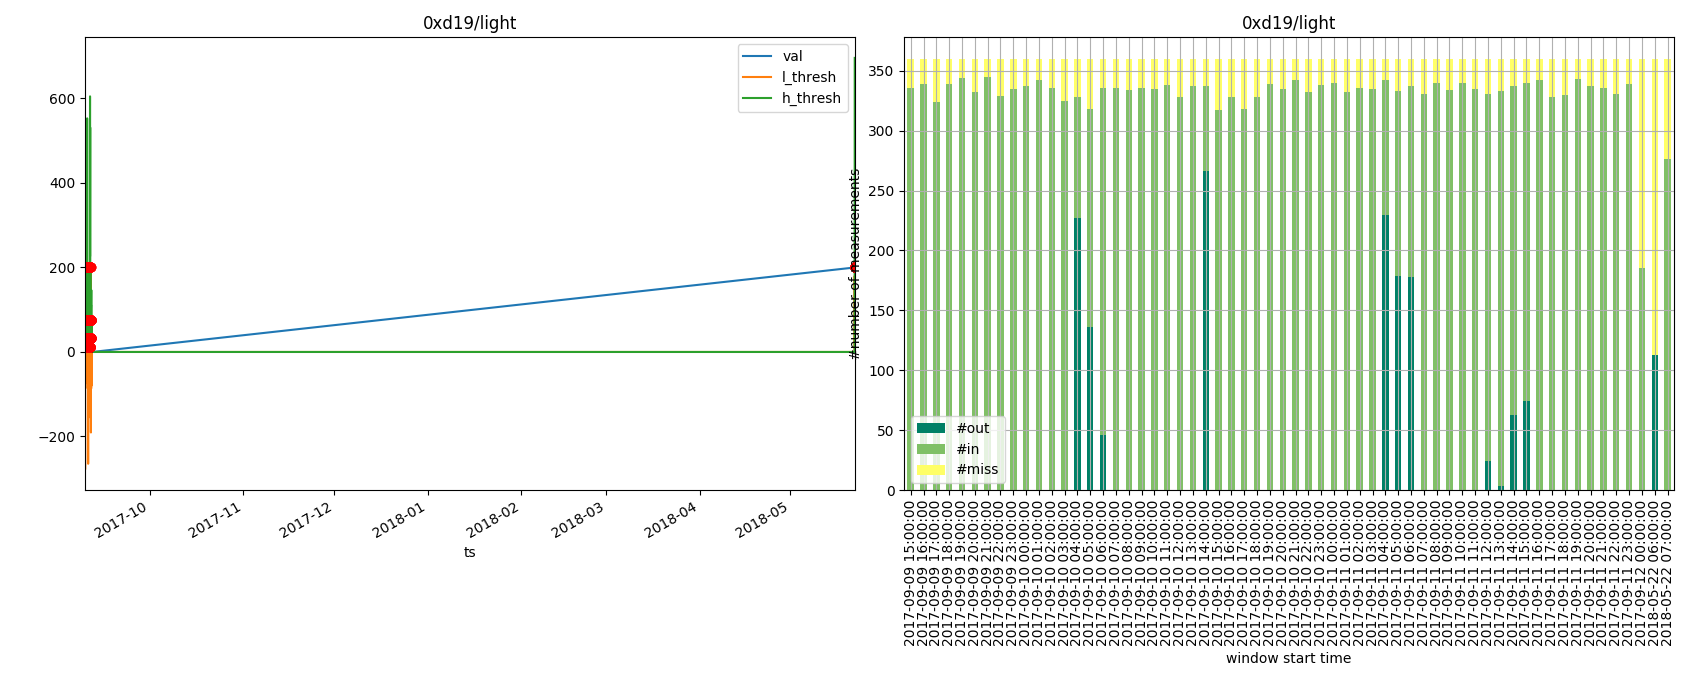

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

<IPython.core.display.Javascript object>


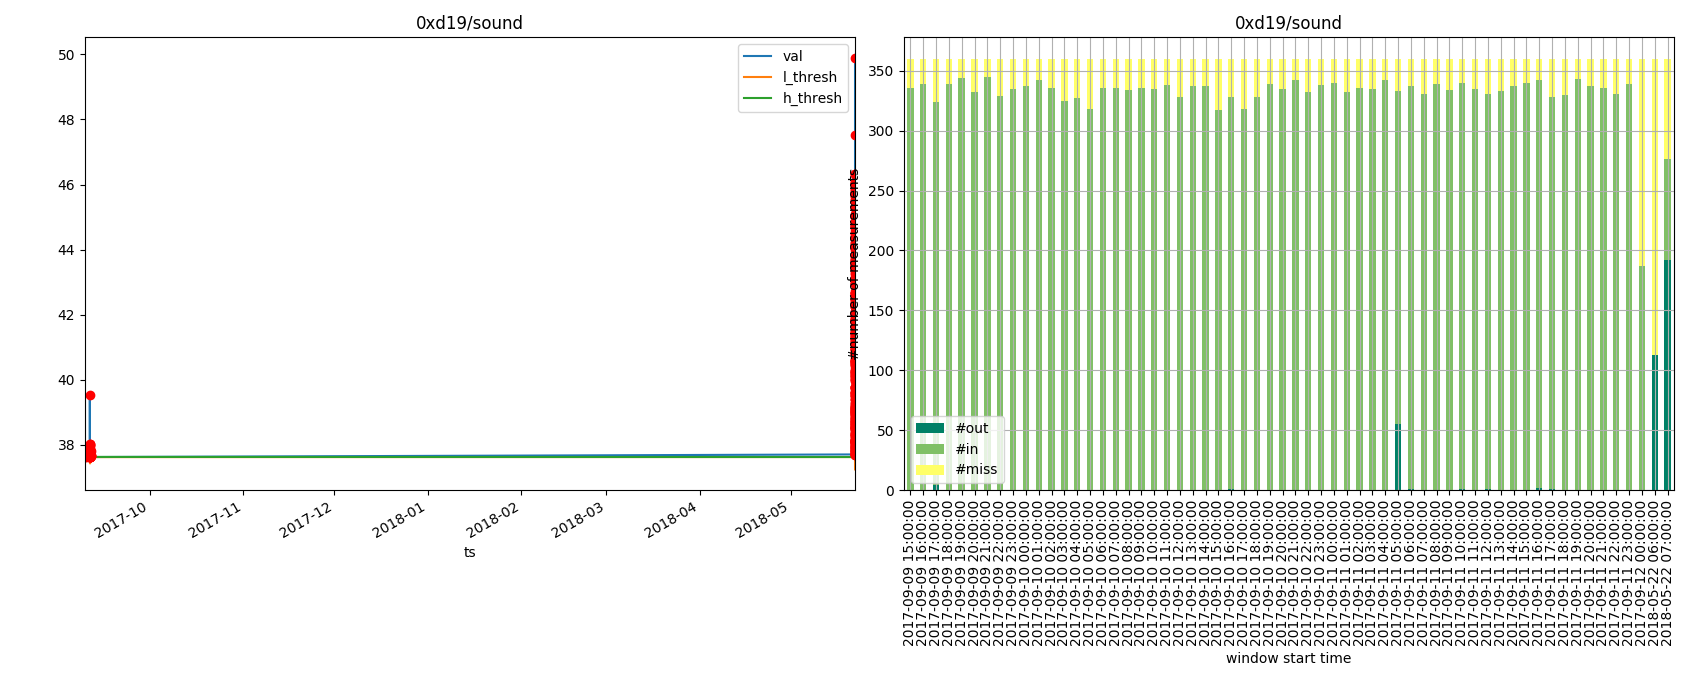

In [7]:
for x in [t_path[2], l_path[2], s_path[2]]:
    path = os.path.join(root, x)
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    #ARIMA_slider(df).plot.line(x=0, y=[1,2,3,4])
    y, x = ARIMA_slider(df)
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    x.plot(ax = ax[0], x = 1, y = [2,4,5], kind='line', title = name)
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[6]
        if boolean == -1:
            ax[0].plot(ts, val, 'ro-')
    ax[0].xaxis_date()

    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax[1], kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax[1].set_xlabel('window start time')
    ax[1].set_ylabel('#number of measurements')
    ax[1].xaxis_date()
    ax[1].legend()
    ax[1].grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
    
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

<IPython.core.display.Javascript object>


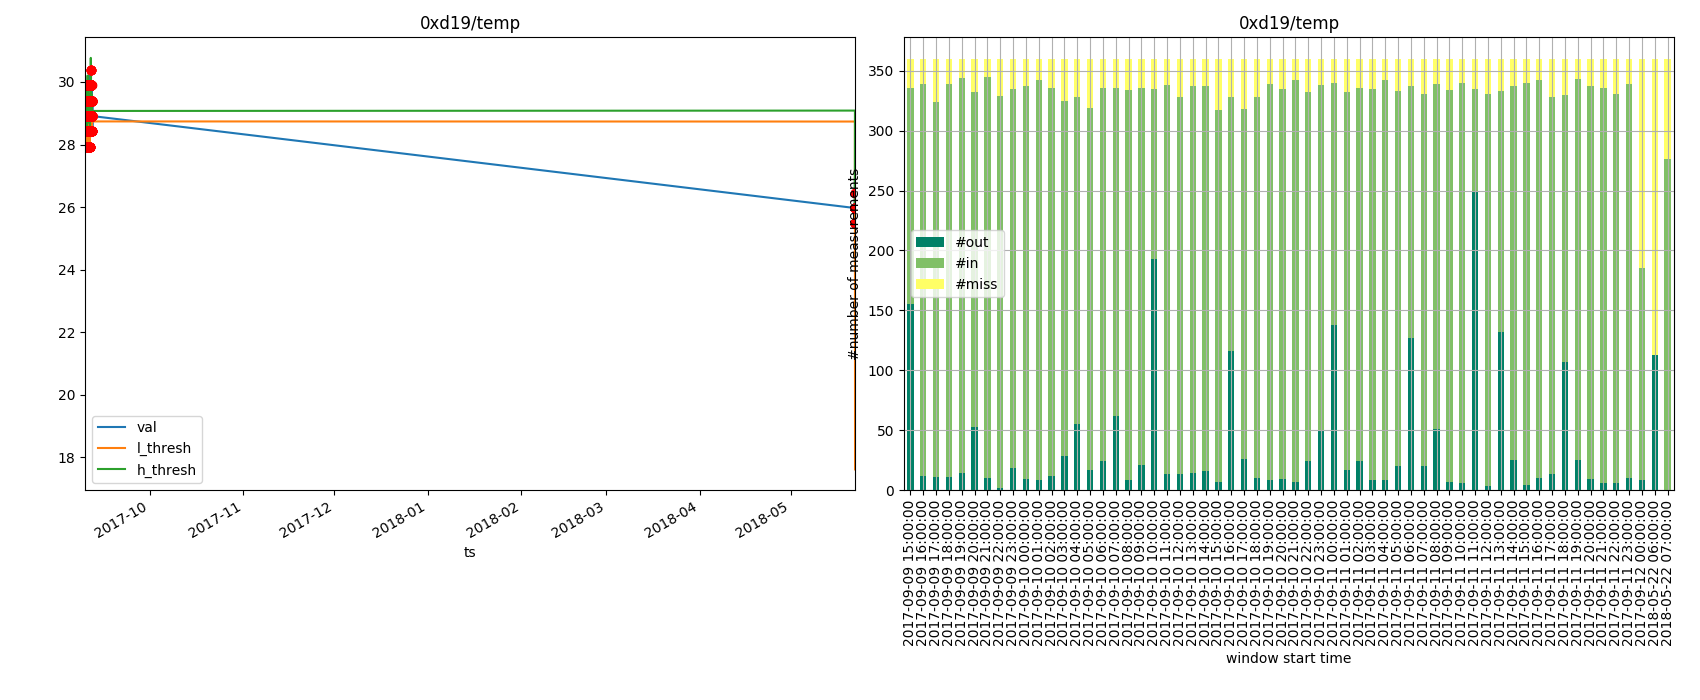

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

<IPython.core.display.Javascript object>


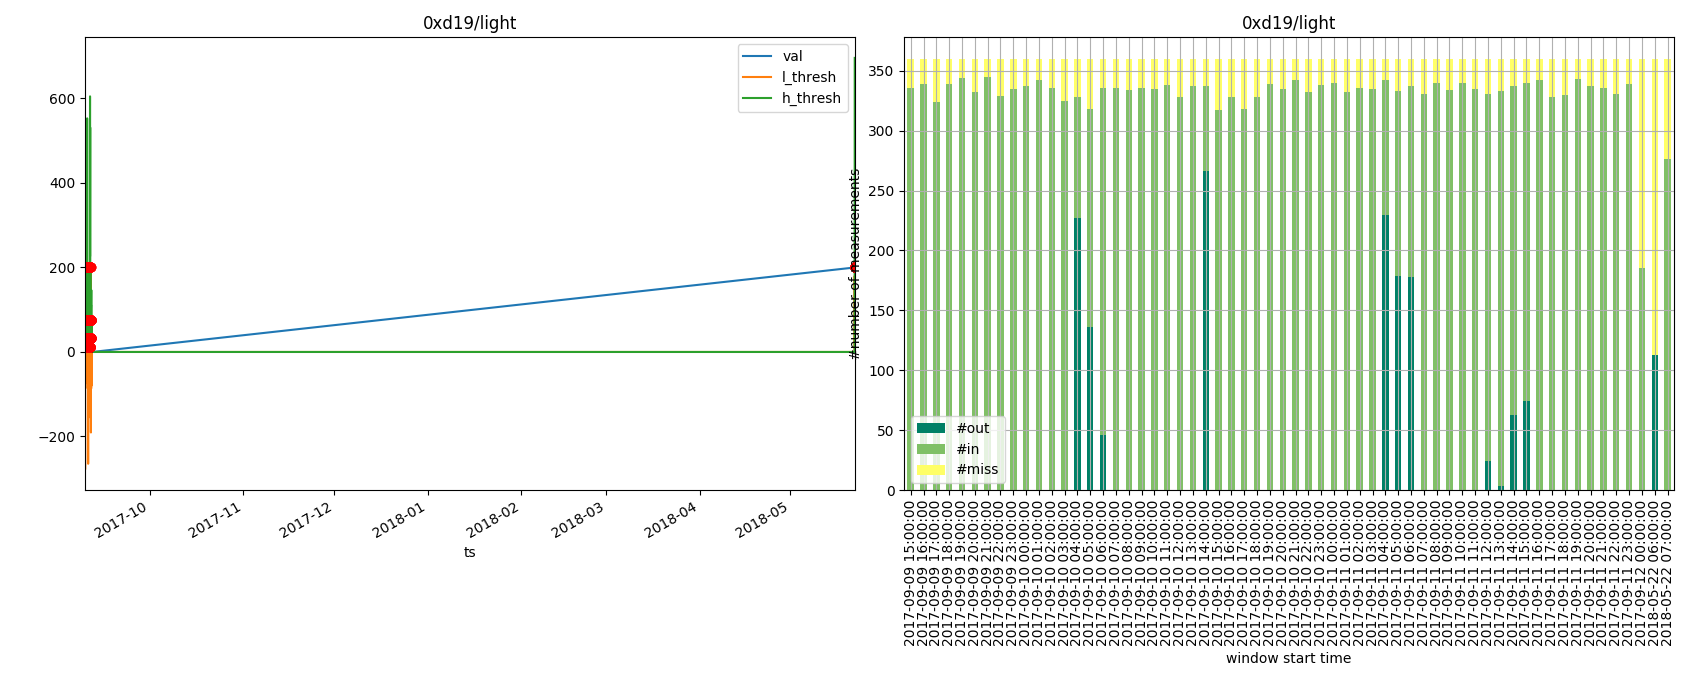

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/home/yanuba/Repos/DM/DMenv/lib/python3.6/site-packages/pmdarima/arima/auto.py:403: User

<IPython.core.display.Javascript object>


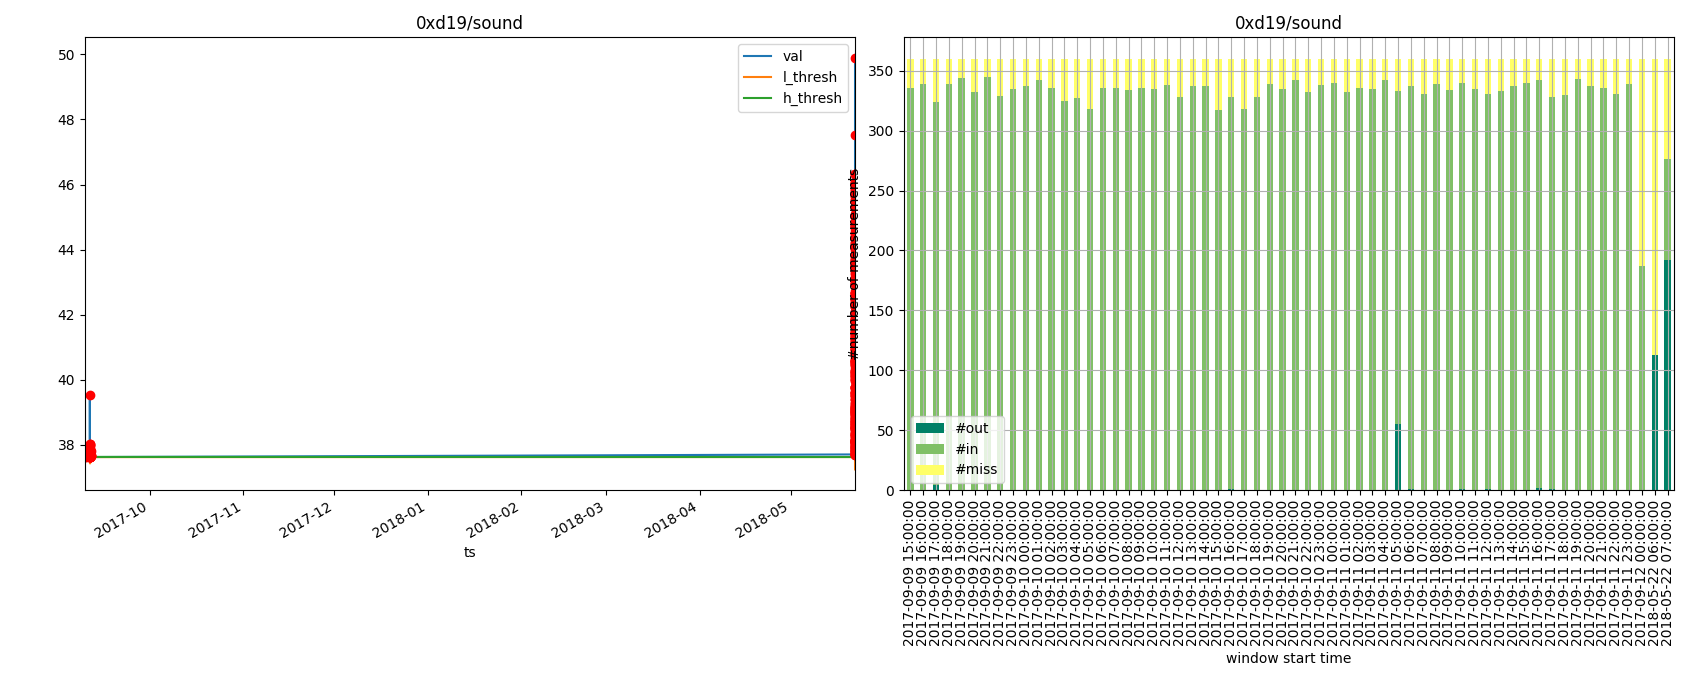

In [8]:
for x in [t_path[2], l_path[2], s_path[2]]:
    path = os.path.join(root, x)
    df = pd.read_csv(path, header=None)
    
    name = df.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    #ARIMA_slider(df).plot.line(x=0, y=[1,2,3,4])
    y, x = ARIMA_slider(df)
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    x.plot(ax = ax[0], x = 1, y = [2,4,5], kind='line', title = name)
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[6]
        if boolean == -1:
            ax[0].plot(ts, val, 'ro-')
    ax[0].xaxis_date()

    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax[1], kind = 'bar', stacked = 'True', colormap = 'summer', title = name)

    ax[1].set_xlabel('window start time')
    ax[1].set_ylabel('#number of measurements')
    ax[1].xaxis_date()
    ax[1].legend()
    ax[1].grid()
    
    num_out = y.iloc[:,3].values.sum()
    num_in = y.iloc[:,4].values.sum()
    num_missed = y.iloc[:,5].values.sum()
    
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

|sensor|#outliers|#inliers|#missing|%outliers|
|---|---|---|---|---|
|0x3bd/temp|3530|16102|6288|17.98084759576202|
|0x3bd/light|1385|18247|6288|7.05480847595762|
|0x3bd/sound|1787|17845|6288|9.102485737571312|
|0xfef/temp|1992|17646|1962|10.143599144515735|
|0xfef/light|1872|17766|1962|9.532538955087077|
|0xfef/sound|225|19413|1962|1.1457378551787352|
|0xd19/temp|2182|17457|1961|11.110545343449258|
|0xd19/light|1539|18100|1961|7.836447884311829|
|0xd19/sound|371|19268|1961|1.889098222923774|
|0xd19/temp|2182|17457|1961|11.110545343449258|
|0xd19/light|1539|18100|1961|7.836447884311829|
|0xd19/sound|371|19268|1961|1.889098222923774|
